In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import jax.numpy as jnp
import jax
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import seaborn as sns
import pickle
import copy

import src.metrics as metrics
import src.kernels as kernels
import src.bootstrap as boot
import src.exp_utils as exp_utils
import experiments.kef as exp_kef
import experiments.efm as exp_efm

# Exploration

In [72]:
L = 5
params = np.ones((L,))
kef = exp_kef.KernelExpFamily(params=params, bw=np.sqrt(2), L=L, p0_loc=0., p0_scale=1.)

In [19]:
np.random.seed(2024)

X = np.reshape(np.linspace(-5., 5, 1001), (-1,))
lp = [kef.log_unnormalised_density(xx) for xx in X]

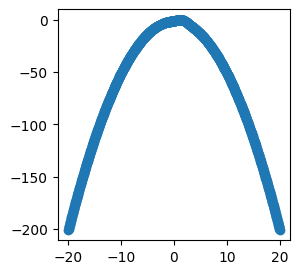

In [20]:
_, ax = plt.subplots(figsize=(3,3))

ax.scatter(X, lp)

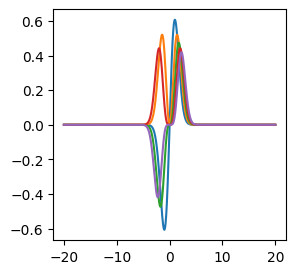

In [38]:
_, ax = plt.subplots(figsize=(3, 3))

phi_vals = np.array([kef.t(x) for x in X])
for l in range(phi_vals.shape[-1]):
    ax.plot(X, phi_vals[:, l])

In [42]:
x = X[400]
jnp.atleast_2d(jax.jacfwd(kef.t)(x))

Array([[-0.00503194,  0.01328365, -0.02848603,  0.0525896 , -0.08623553]],      dtype=float32)

In [57]:
import experiments.efm as exp_efm

efm_model = exp_efm.EFM(np.ones((2,)) * 0.)

x = jnp.array([-.1, .2, 0.3, 0.2, -0.7])
score_approx = jnp.atleast_2d(jax.jacfwd(efm_model.log_unnormalised_density)(x))
print("score_approx", score_approx)

x = jnp.array([[-.1, .2, 0.3, 0.2, -0.7]])
score_exact, _ = efm_model.compute_grad_and_hvp(x)
print("score_exact", score_exact)

JT_approx = jax.jacfwd(efm_model.t)(x)
JT_exact, _, _ = efm_model._compute_grads(x)
print("JT_approx", JT_approx)
print("JT_exact", JT_exact)

score_approx [[ 0.18       -0.26       -0.32000002 -0.22        0.68      ]]
score_exact [[ 0.18       -0.26       -0.32000002 -0.22        0.68      ]]
JT_approx [[[[0.        0.        0.        0.961043  0.       ]]

  [[0.        0.        0.        0.        0.6347395]]]]
JT_exact [[[0.        0.        0.        0.961043  0.       ]
  [0.        0.        0.        0.        0.6347396]]]


In [66]:
x = np.random.normal(size=(100, 5))

JT = jax.vmap(lambda x: jax.jacfwd(efm_model.t)(x))(x)

In [70]:
x = np.random.normal(size=(100, 1))

JT = jax.vmap(lambda x: jax.jacfwd(kef.t)(x))(x)
JT.shape

(100, 5, 1)

# Galaxy data

In [2]:
ys, unnormalize = exp_kef.load_galaxies("../data/kef/galaxies.rda")

# standardise
# ys /= ys.std()

/home/ma/x/xl6116/.envs/robust/lib/python3.8/site-packages/rdata/parser/_parser.py:839: UserWarning: Tag not implemented for type RObjectType.CHAR and ignored
  warnings.warn(
/home/ma/x/xl6116/.envs/robust/lib/python3.8/site-packages/rdata/parser/_parser.py:839: UserWarning: Tag not implemented for type RObjectType.REAL and ignored
  warnings.warn(
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


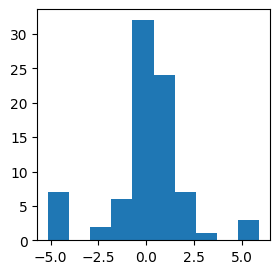

In [3]:
_, ax = plt.subplots(figsize=(3,3))

_ = ax.hist(np.squeeze(ys))

In [113]:
np.random.seed(2024)

add_outliers = True

# 1. pure data
X = np.reshape(ys, (-1, 1))

# split
n = X.shape[0]
ntest = int(.5 * n)
idx = np.random.choice(range(n), size=ntest, replace=False)
X_test_raw = X[idx]
X = X[jnp.array([i for i in range(n) if i not in idx])]

# 2. contam data
if add_outliers:
    eps = 0.3
    ol_mean = 30.
    X = exp_efm.sample_outlier_contam(X, eps=eps, ol_mean=ol_mean, ol_std=0.1)

In [114]:
L = 25
kef_l = jnp.sqrt(2)
kef_p0_std = 3.0
params = np.ones((L,))
kef = exp_kef.KernelExpFamily(params=params, bw=kef_l, L=L, p0_loc=0., p0_scale=kef_p0_std)

In [115]:
# kernel = kernels.SumKernel([kernels.IMQ(sigma_sq=2*l**2) for l in [0.6, 1.0, 1.2]])
# kernel = kernels.IMQ(med_heuristic=True, X=X, Y=X)
# kernel = kernels.IMQ(sigma_sq=2*1**2, X=X, Y=X)

# poly_weight_fn = kernels.PolyWeightFunction(a=X.std())
poly_weight_fn = kernels.PolyWeightFunction(a=1.)
kernel0 = kernels.IMQ(sigma_sq=2*1.**2, X=X, Y=X)
kernel = kernels.TiltedKernel(kernel=kernel0, weight_fn=poly_weight_fn)

est_params = kef.ksd_est(X, kernel)
print("est_params", est_params)

est_params [-1.10284865e+00 -1.54068351e+00  2.53874230e+00 -1.63789427e+00
  5.60183227e-01 -1.37054777e+00 -2.33982697e-01 -1.16431296e+00
 -3.74474794e-01 -8.40884209e-01 -3.30795199e-01 -5.09413600e-01
 -2.34452128e-01 -2.65403271e-01 -1.41496271e-01 -1.20168194e-01
 -7.74790719e-02 -4.60282564e-02 -4.21341881e-02 -1.28613422e-02
 -2.44505052e-02 -3.39953840e-04 -1.44668641e-02  2.55035167e-03
 -6.86563458e-03]


In [116]:
trained_kef_model = exp_kef.KernelExpFamily(est_params, bw=kef_l, L=L, p0_loc=0., p0_scale=kef_p0_std)

In [117]:
seed = jax.random.PRNGKey(seed=56789)

X_plot = np.reshape(np.linspace(-10., 10., 1001), (-1, 1))
approx_prob = trained_kef_model.approx_prob(seed, xs=X_plot, n_samples=2000)

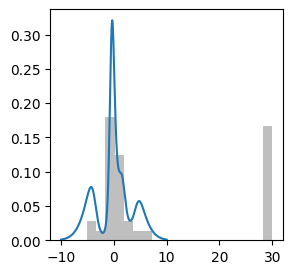

In [118]:
# contam
_, ax = plt.subplots(figsize=(3,3))

# ax.hist(np.squeeze(ys), density=True)
ax.hist(X.reshape(-1), color="grey", alpha=0.5, bins=20, density=True)
ax.plot(X_plot, approx_prob)
# ax.set_xlim(-10., 10.)

#### Test

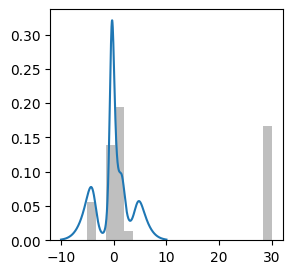

In [119]:
if add_outliers:
    X_test = exp_efm.sample_outlier_contam(X_test_raw, eps=eps, ol_mean=ol_mean, ol_std=0.1)
else:
    X_test = X_test_raw
# X_test = X_test[X_test < 7.].reshape((-1, 1))

score = jax.vmap(trained_kef_model.score)(X_test)

_, ax = plt.subplots(figsize=(3,3))
ax.hist(X_test.reshape(-1), color="grey", alpha=0.5, bins=20, density=True)
ax.plot(X_plot, approx_prob)

In [120]:
# np.random.seed(321)

# test_kernel = kernel
# test_kernel = kernels.IMQ(sigma_sq=2*1**2, X=X, Y=X)

# poly_weight_fn = kernels.PolyWeightFunction(a=X.std())
poly_weight_fn = kernels.PolyWeightFunction(a=1.)
kernel0 = kernels.IMQ(sigma_sq=2*1.**2)
test_kernel = kernels.TiltedKernel(kernel=kernel0, weight_fn=poly_weight_fn)

ksd = metrics.KSD(test_kernel)
wild_boot = boot.WildBootstrap(ksd)
pval, stat, boot_stats = wild_boot.pval(X_test, X_test, return_stat=True, return_boot=True, score=score, hvp=None)

In [121]:
pval

Array(0.22577423, dtype=float32, weak_type=True)

In [128]:
weight_fn_args = {"a": X.std()}
theta = 0.1**0.5

X_test_b = jnp.reshape(X_test, (1, -1, 1))
score_b = jnp.reshape(score, (1, -1, 1))
test_res = exp_utils.run_tests(
    samples=X_test_b, scores=score_b, hvps=None, hvp_denom_sup=None, 
    theta=theta, bw=2.*1**2, alpha=0.05, verbose=True, base_kernel="IMQ", weight_fn_args=weight_fn_args,
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.40it/s]


In [129]:
test_res["tilted"]["rej"]

[1]

In [130]:
print("dev", test_res["tilted_robust_dev"]["rej"])
print("boot", test_res["tilted_robust_boot"]["rej"])

dev [0]
boot [0]


#### use code from Key et al 

In [425]:
from src.kcomp.bootstrapped_tests import (
    Bootstrap,
    parametric_bootstrap_test,
    wild_bootstrap_test,
)

from src.kcomp.distributions.kef import kernel_exp_family
from src.kcomp.kernels import IMQKernel, SumKernel
from src.kcomp.ksd import KSDAnalyticEstimator, KSDStatistic
from src.kcomp.rejection_sampler import LowAcceptanceError

from experiments.efm import sample_outlier_contam

In [346]:
# 1. pure data
X = ys

# 2. contam data
# X = sample_outlier_contam(ys, eps=0.1, ol_mean=5., ol_std=0.1)

In [360]:
rng = jax.random.PRNGKey(seed=56789)

kef_l = jnp.sqrt(2)
kef_q0_std = 3.0

# kernel = SumKernel([IMQKernel(l) for l in [0.6, 1.0, 1.2]])
kernel = IMQKernel(.6)
# test_ps = [1, 2, 3, 4, 5, 25]
L = 25

null = kernel_exp_family(L, kef_l, q0_std=kef_q0_std)
test_stat = KSDStatistic(kernel, null)
estimator = KSDAnalyticEstimator(kernel, null)

rng, rng_input = jax.random.split(rng)
test_result = wild_bootstrap_test(
    rng_input,
    X,
    estimator,
    test_stat,
    n_bootstrap_samples=500,
    save_null_distribution=False,
)

In [361]:
test_result.theta_hat

Array([-1.4936023 ,  0.4768291 ,  5.0071507 , -5.2358356 , -0.13066   ,
       -2.7816918 , -0.6536812 , -1.3812765 , -0.1835363 , -1.0591702 ,
        0.16677836, -1.0724868 ,  0.33188555, -1.0265937 ,  0.2763928 ,
       -0.7605494 , -0.01352196, -0.26332438, -0.4435546 ,  0.3559273 ,
       -0.8376432 ,  0.9226108 , -1.0316159 ,  1.2795163 , -0.95474637],      dtype=float32)

In [362]:
test_result.reject_null

False

In [363]:
# null(test_result.theta_hat)

In [364]:
trained_kef_model = exp_kef.KernelExpFamily(test_result.theta_hat, bw=np.sqrt(2), L=L, p0_loc=0., p0_scale=kef_q0_std)

In [365]:
seed = jax.random.PRNGKey(seed=56789)

X_plot = np.reshape(np.linspace(-10., 10., 1001), (-1, 1))
approx_prob = trained_kef_model.approx_prob(seed, xs=X_plot, n_samples=2000)

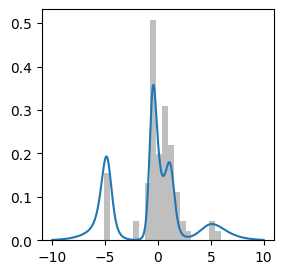

In [366]:
_, ax = plt.subplots(figsize=(3,3))

ax.hist(X.reshape(-1), color="grey", alpha=0.5, bins=20, density=True)
ax.plot(X_plot, approx_prob)

In [329]:
kernel = IMQKernel(1.)
null = kernel_exp_family(L, kef_l, q0_std=kef_q0_std)
estimator = KSDAnalyticEstimator(kernel, null)
estimator(None, X)

big_lambda_n [[ 0.10926925 -0.01898558  0.0572874   0.00991449  0.02270504]
 [-0.01898559  0.01049798 -0.0067044   0.00323491 -0.00144764]
 [ 0.05728738 -0.0067044   0.03412957  0.0090801   0.01507667]
 [ 0.00991448  0.00323491  0.0090801   0.00553043  0.00515309]
 [ 0.02270505 -0.00144764  0.01507668  0.00515309  0.00725382]]
nu_n [-0.04348493  0.04131965 -0.00364204  0.02598427  0.00794143]
eta_estimate [-0.92201036  0.47297215  3.8515208  -5.9567223  -1.3223526 ]
theta_estimate [-0.92201036  0.47297215  3.8515208  -5.9567223  -1.3223526 ]


Array([-0.92201036,  0.47297215,  3.8515208 , -5.9567223 , -1.3223526 ],      dtype=float32)

In [337]:
kernel = kernels.IMQ(sigma_sq=2*1.**2)
est_params = kef.ksd_est(X, kernel)

In [338]:
est_params

Array([-0.9219946,  0.4730076,  3.8514888, -5.956779 , -1.3222908],      dtype=float32)

# Synthetic data

In [131]:
def sample_from_mixture(n):
    means = [-5., 0., 5.]
    stds = [0.1, .5, 0.1]
    ratios = [0.1, 0.85, 0.05]
    ns = np.random.multinomial(n, ratios, size=1).astype(np.int64)
    X_ls = []
    for i in range(len(means)):
        X_ls.append(np.random.normal(loc=np.array(means[i]), scale=np.array(stds[i]), size=(ns[0][i], 1)))

    X = np.concatenate(X_ls, 0)
    return jnp.array(X)

In [134]:
np.random.seed(2024)

add_outlier = True
n = 200
ntest = 200

# 1. pure data
X = sample_from_mixture(n)

# # remove "outliers"
# X = X[X < 2.5]
# X = np.reshape(X[X > -2.5], (-1, 1))

# # 2. contam data
if add_outlier:
    eps = 0.2
    ol_mean = 30.
    X = exp_efm.sample_outlier_contam(X, eps=eps, ol_mean=ol_mean, ol_std=0.1)

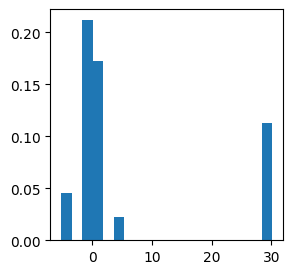

In [135]:
_, ax = plt.subplots(figsize=(3, 3))

_ = ax.hist(jnp.squeeze(X), bins=20, density=True)

In [136]:
L = 25
kef_l = jnp.sqrt(2)
kef_p0_std = 3.
params = np.ones((L,))
kef = exp_kef.KernelExpFamily(params=params, bw=kef_l, L=L, p0_loc=0., p0_scale=kef_p0_std)

In [137]:
# kernel = kernels.SumKernel([kernels.IMQ(sigma_sq=2*l**2) for l in [0.6, 1.0, 1.2]])
# kernel = kernels.IMQ(med_heuristic=True, X=X, Y=X)
# kernel = kernels.IMQ(sigma_sq=2*1.**2, X=X, Y=X)

poly_weight_fn = kernels.PolyWeightFunction(a=X.std())
kernel0 = kernels.IMQ(sigma_sq=2*1.**2, X=X, Y=X)
kernel = kernels.TiltedKernel(kernel=kernel0, weight_fn=poly_weight_fn)

est_params = kef.ksd_est(X, kernel)
print("est_params", est_params)

est_params [ 0.05375558 -4.044751    0.23437263 -2.0631454  -0.02733332 -0.6693382
 -0.02715073 -0.24299042 -0.00818898 -0.22262044 -0.00623433 -0.34023702
 -0.02121954 -0.48246095 -0.05378525 -0.5745202  -0.10080415 -0.56032616
 -0.1508261  -0.4196625  -0.18606296 -0.17903969 -0.18993507  0.09954733
 -0.15520178]


In [138]:
trained_kef_model = exp_kef.KernelExpFamily(est_params, bw=kef_l, L=L, p0_loc=0., p0_scale=kef_p0_std)

In [139]:
seed = jax.random.PRNGKey(seed=56789)
X_plot = np.reshape(np.linspace(-10., 10., 1001), (-1, 1))
approx_prob = trained_kef_model.approx_prob(seed, xs=X_plot, n_samples=2000)

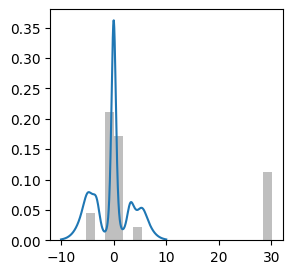

In [140]:
_, ax = plt.subplots(figsize=(3,3))
ax.hist(X.reshape(-1), color="grey", alpha=0.5, bins=20, density=True)
ax.plot(X_plot, approx_prob)

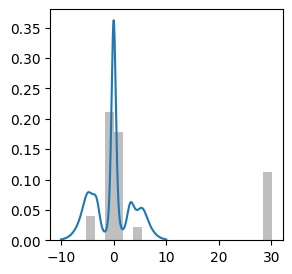

In [141]:
# # generate independent sample for testing
X_test = sample_from_mixture(ntest)
# X_test = sample_from_mixture(500)

if add_outlier:
    X_test = exp_efm.sample_outlier_contam(X_test, eps=eps, ol_mean=ol_mean, ol_std=0.1)

_, ax = plt.subplots(figsize=(3,3))
ax.hist(X_test.reshape(-1), color="grey", alpha=0.5, bins=20, density=True)
ax.plot(X_plot, approx_prob)

In [142]:
# test 
score = jax.vmap(trained_kef_model.score)(X_test)

# test_kernel = kernel
# test_kernel = kernels.IMQ(sigma_sq=2*1.**2, X=X, Y=X)

poly_weight_fn = kernels.PolyWeightFunction(a=X_test.std())
kernel0 = kernels.IMQ(sigma_sq=2*1.**2)
test_kernel = kernels.TiltedKernel(kernel=kernel0, weight_fn=poly_weight_fn)


ksd = metrics.KSD(test_kernel)
wild_boot = boot.WildBootstrap(ksd)
pval, stat, boot_stats = wild_boot.pval(X_test, X_test, return_stat=True, return_boot=True, score=score, hvp=None)

In [143]:
pval

Array(0.03196803, dtype=float32, weak_type=True)

In [146]:
weight_fn_args = {"a": X_test.std()}
theta = 0.1

X_test_b = jnp.reshape(X_test, (1, -1, 1))
score_b = jnp.reshape(score, (1, -1, 1))
test_res = exp_utils.run_tests(
    samples=X_test_b, scores=score_b, hvps=None, hvp_denom_sup=None, 
    theta=theta, bw=2.*1**2, alpha=0.05, verbose=True, base_kernel="RBF", weight_fn_args=weight_fn_args,
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.17s/it]


In [147]:
test_res["tilted"]["pval"]

[Array(0.02597403, dtype=float32, weak_type=True)]

In [148]:
print("dev", test_res["tilted_robust_dev"]["rej"])
print("boot", test_res["tilted_robust_boot"]["rej"])

dev [0]
boot [0]


In [149]:
print("stat", test_res["tilted_robust_boot"]["stat"])
print("threshold", test_res["tilted_robust_boot"]["threshold"])

stat [Array(0.07975142, dtype=float32)]
threshold [0.08719755470752713]


In [166]:
theta_new = 0.003**0.5
test_res_new = copy.deepcopy(test_res)
test_res_new = exp_utils.change_theta(test_res, ["tilted_robust_dev", "tilted_robust_clt", "tilted_robust_boot"], theta_new)

0.08019755470752712


In [167]:
print("dev", test_res_new["tilted_robust_dev"]["rej"])
print("boot", test_res_new["tilted_robust_boot"]["rej"])

dev [0]
boot [0]


In [150]:
tau = test_res["tilted_robust_dev"]["tau"][0]
0.1 * tau**0.5

Array(1.2311213, dtype=float32)

In [579]:
ksd = test_res["tilted_robust_dev"]["ksd_class"][0]

In [586]:
xx = jnp.array([[w] for w in [0., 1., 10., 30.]])
ss = jax.vmap(trained_kef_model.score)(xx)
ksd(xx, xx, score=ss, output_dim=2, vstat=True)

Array([[ 1.1577858e+00, -2.4974749e+00, -1.8066440e-20,  0.0000000e+00],
       [-2.4974749e+00,  8.0888834e+00, -1.3248710e-16,  0.0000000e+00],
       [-1.8066440e-20, -1.3248707e-16,  1.5360247e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  2.2207808e+00]],      dtype=float32)

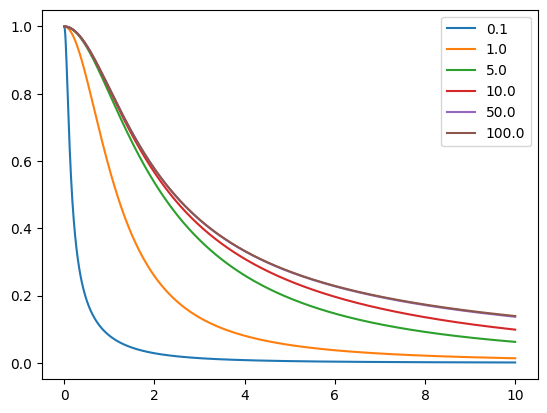

In [196]:
# weighting function
x_kernel = np.linspace(-0, 10., 1001).reshape((-1, 1))

for a in [0.1, 1., 5., 10., 50., 100.]:
    poly_weight_fn = kernels.PolyWeightFunction(a=a)
    kernel0 = kernels.IMQ(sigma_sq=2*1.**2, X=x_kernel, Y=x_kernel)
    kernel = kernels.TiltedKernel(kernel=kernel0, weight_fn=poly_weight_fn)
    
    kk_mat = kernel(x_kernel, x_kernel)
    
    _ = plt.plot(x_kernel[:, 0], kk_mat[0], label=a)

_ = plt.legend()